In [141]:
# to_save, to_load = False, True
session_file = "./tmp/TIC_417657237_EA_w_ETV_apsidal_motion.ipynb.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import sys
#     if "../" not in sys.path:  # to get my usual helpers at base dir
#         sys.path.append("../")
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/TIC_417657237_EA_w_ETV_apsidal_motion.ipynb.pkl


In [120]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, MultipleLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 417657237 / KID 11761199 Analysis (EA)

- existing VSX entry, mainly to add the missing period
  - https://vsx.aavso.org/index.php?view=detail.top&oid=243063
- not full analysis, populate missing / outdated feilds with the values from the latest version of Kepler EBs
    - https://keplerebs.villanova.edu/overview/?k=11761199
    - https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ695eedd642bef&-out.add=.&-source=J/AJ/151/68/catalog&recno=2793

## TESS Data

In [20]:
tic = 417657237
sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 74 2024   SPOC     120   417657237      0.0      G06085
  1 TESS Sector 75 2024   SPOC     120   417657237      0.0      G06085
  2 TESS Sector 80 2024   SPOC     120   417657237      0.0      G06085
  3 TESS Sector 81 2024   SPOC     120   417657237      0.0      G06085
  4 TESS Sector 82 2024   SPOC     120   417657237      0.0      G06085

LightCurveCollection of 5 objects:
    0: <TessLightCurve LABEL="TIC 417657237" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 417657237" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 417657237" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 417657237" SECTOR=81 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 417657237" SECTOR=82 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

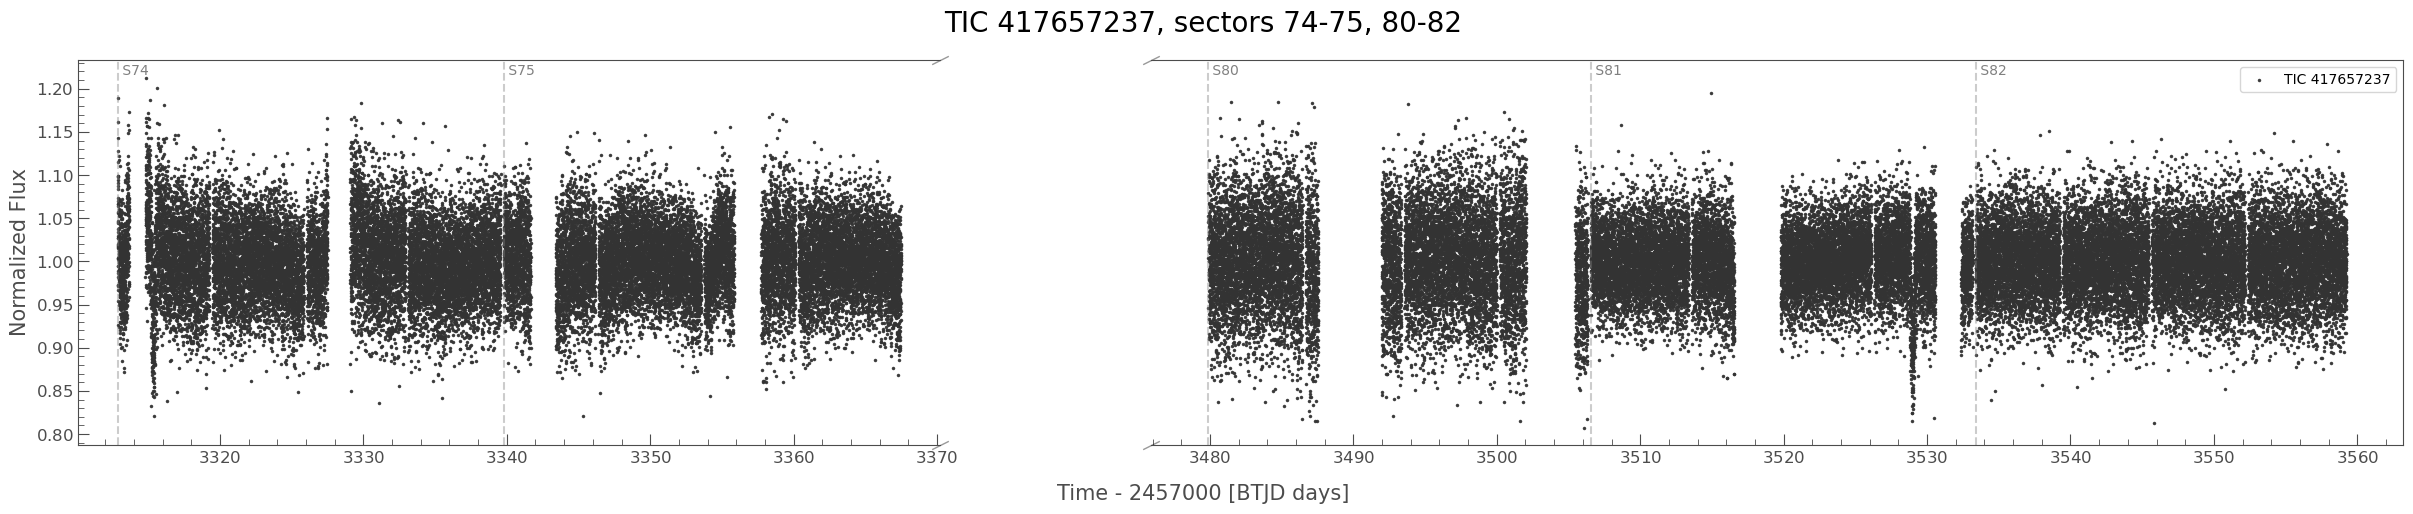

In [21]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(0.9985, 1.001) for ax in axs];

## Gaia DR3 info (coordinate, etc.)

- issue: the target is resolved to 2 stars in Gaia DR3 with similar brightness, ID is not clear.

In [91]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
# *** Uncertain ID, here we arbitrary choose the brighter of the 2 stars as the target_coord ***
target_coord = SkyCoord(rs[1]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


The target is also listed as an AB and SB with ~500 dperiod in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=I/357&-c=17%3A55%3A59.25%20%2B45%3A52%3A26.42&-c.u=arcsec&-c.r=15&-c.eq=J2000&-out.add=_r&-out.add=_p&-sort=_r)


In [26]:
# No change in primary name, and it isn't used
primary_name = "KID 11761199"
primary_name

'KID 11761199'

## Combining all data



### Kepler

In [23]:
sr = lk.search_lightcurve(f"KIC11761199", )  # author="SPOC", cadence="short"
lcc_kp = sr.download_all()
lcc_kp

LightCurveCollection of 17 objects:
    0: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 11761199" QUARTER=10 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <Kepl

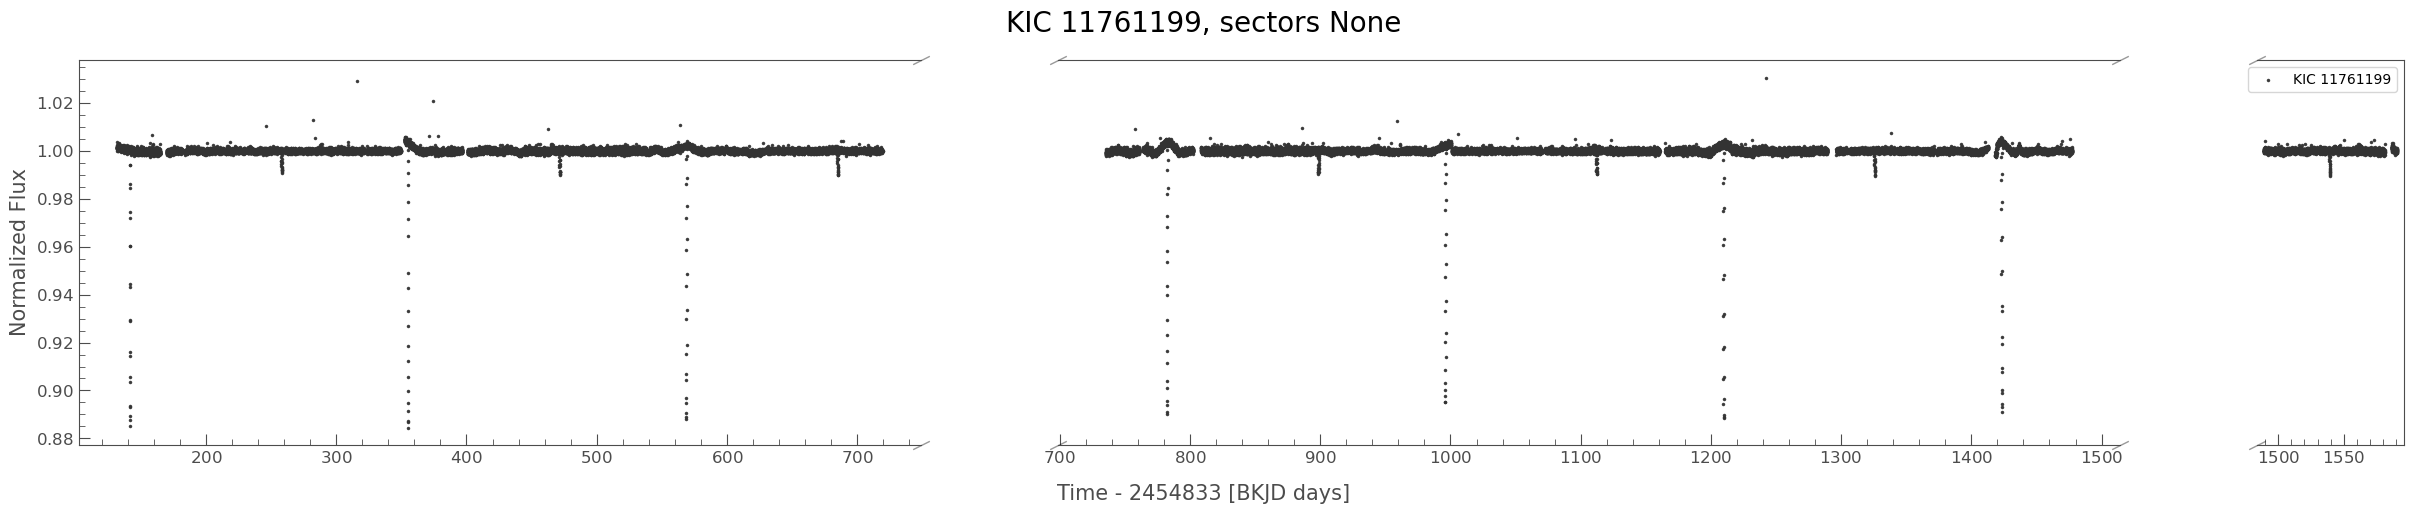

In [24]:
lc = lke.stitch(lcc_kp, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(0.9985, 1.001) for ax in axs];

## ASAS-SN , ZTF (not used)

- ASAS-SN / ZTF data does not appear to have the sufficient photometric precision

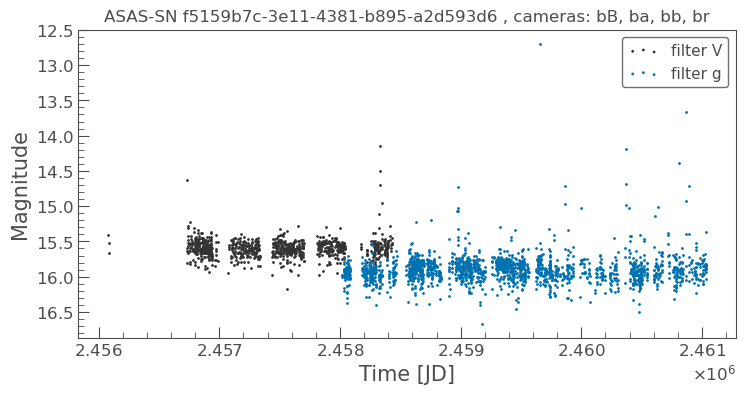

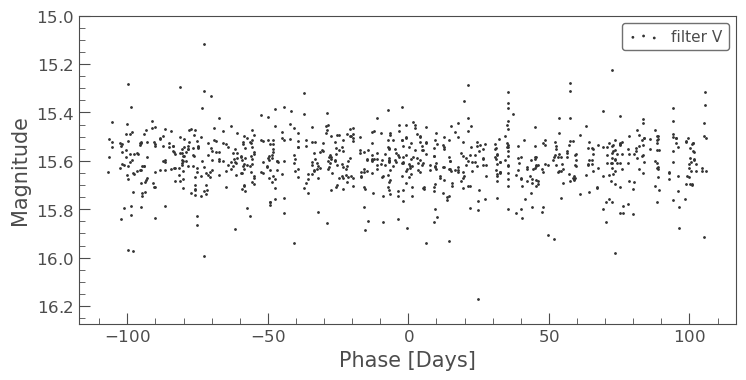

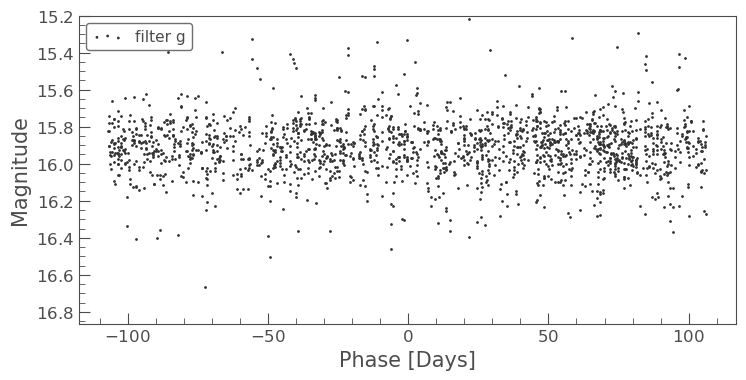

In [20]:
import lightkurve_ext_readers as lker

# https://asas-sn.osu.edu/sky-patrol/coordinate/f5159b7c-3e11-4381-b895-a2d593d63c43
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic417657237_asas_sn_light_curve_f5159b7c-3e11-4381-b895-a2d593d63c43.csv").select_flux("mag")
ax = tplt.scatter_partition_by(lc, "filter");

for filter, ylim in [("V", (None, 15.0)), ("g", (None, 15.2))]:
    _lc = lc[lc.filter == filter]
    lc_f = _lc.fold(epoch_time=round(54974.635062 + 2400000, 1), period=213.628)  # approx epoch /period
    ax = tplt.scatter(lc_f, label=f"filter {filter}");
    ax.set_ylim(*ylim);



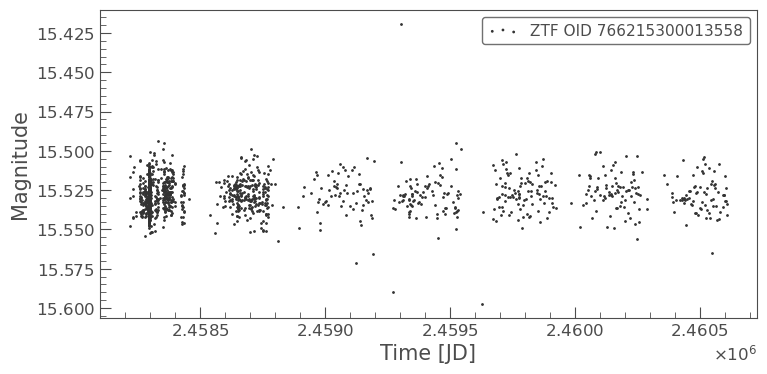

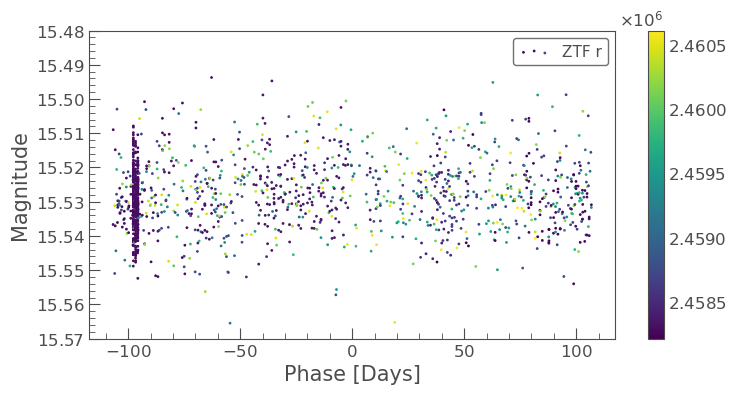

In [26]:
import lightkurve_ext_readers as lker

# r-band
lc = lker.read_ztf_csv("https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID=766215300013558&COLLECTION=ztf_dr23&FORMAT=csv")  # .select_flux("mag")
ax = tplt.scatter(lc);

lc_f = lc.fold(epoch_time=round(54974.635062 + 2400000, 1), period=213.628)  # approx epoch /period
ax = tplt.scatter(lc_f, c=lc_f.time_original.value, label=f"ZTF r");
ax.set_ylim(15.57, 15.48);

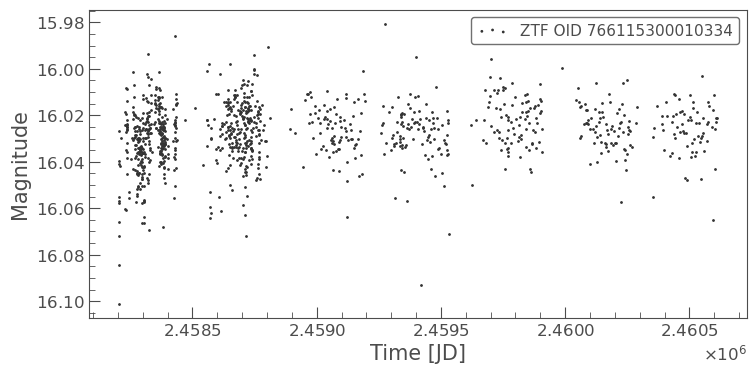

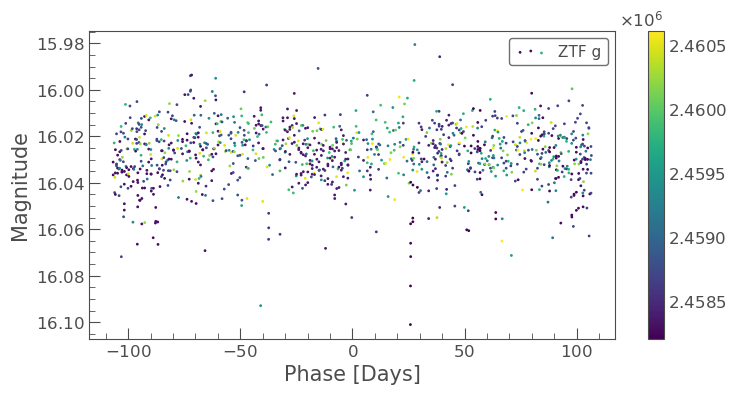

In [25]:
import lightkurve_ext_readers as lker

# g-band
lc = lker.read_ztf_csv("https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID=766115300010334&COLLECTION=ztf_dr23&FORMAT=csv")
ax = tplt.scatter(lc);

lc_f = lc.fold(epoch_time=round(54974.635062 + 2400000, 1), period=213.628)  # approx epoch /period
ax = tplt.scatter(lc_f, c=lc_f.time_original.value, label=f"ZTF g");
# ax.set_ylim(15.57, 15.48);

### Do Actual combining

TESS # data points: 79956
Kp # data points: 64796


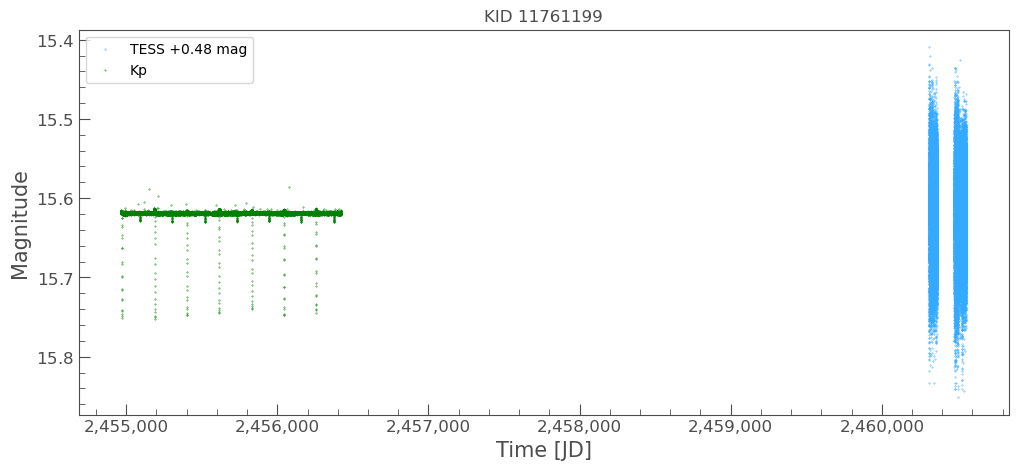

In [31]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

# Note: since we only use TESS / Kepler data, keep the time in BJD

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True).remove_nans().remove_nans(column="flux_err")
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess.time.format = "jd"  

lc_kp = lke.stitch(lcc_kp, ignore_incompatible_column_warning=True).remove_nans().remove_nans(column="flux_err")
lc_kp = lke.to_flux_in_mag_by_normalization(lc_kp)
lc_kp.time.format = "jd"


# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "Kp": lc_kp,
    }, 
    shift_to="Kp",

)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Initial epoch / period / duration


Adopted period / epoch / duration_hr:  213.628 2454974.6 9.228729599999998


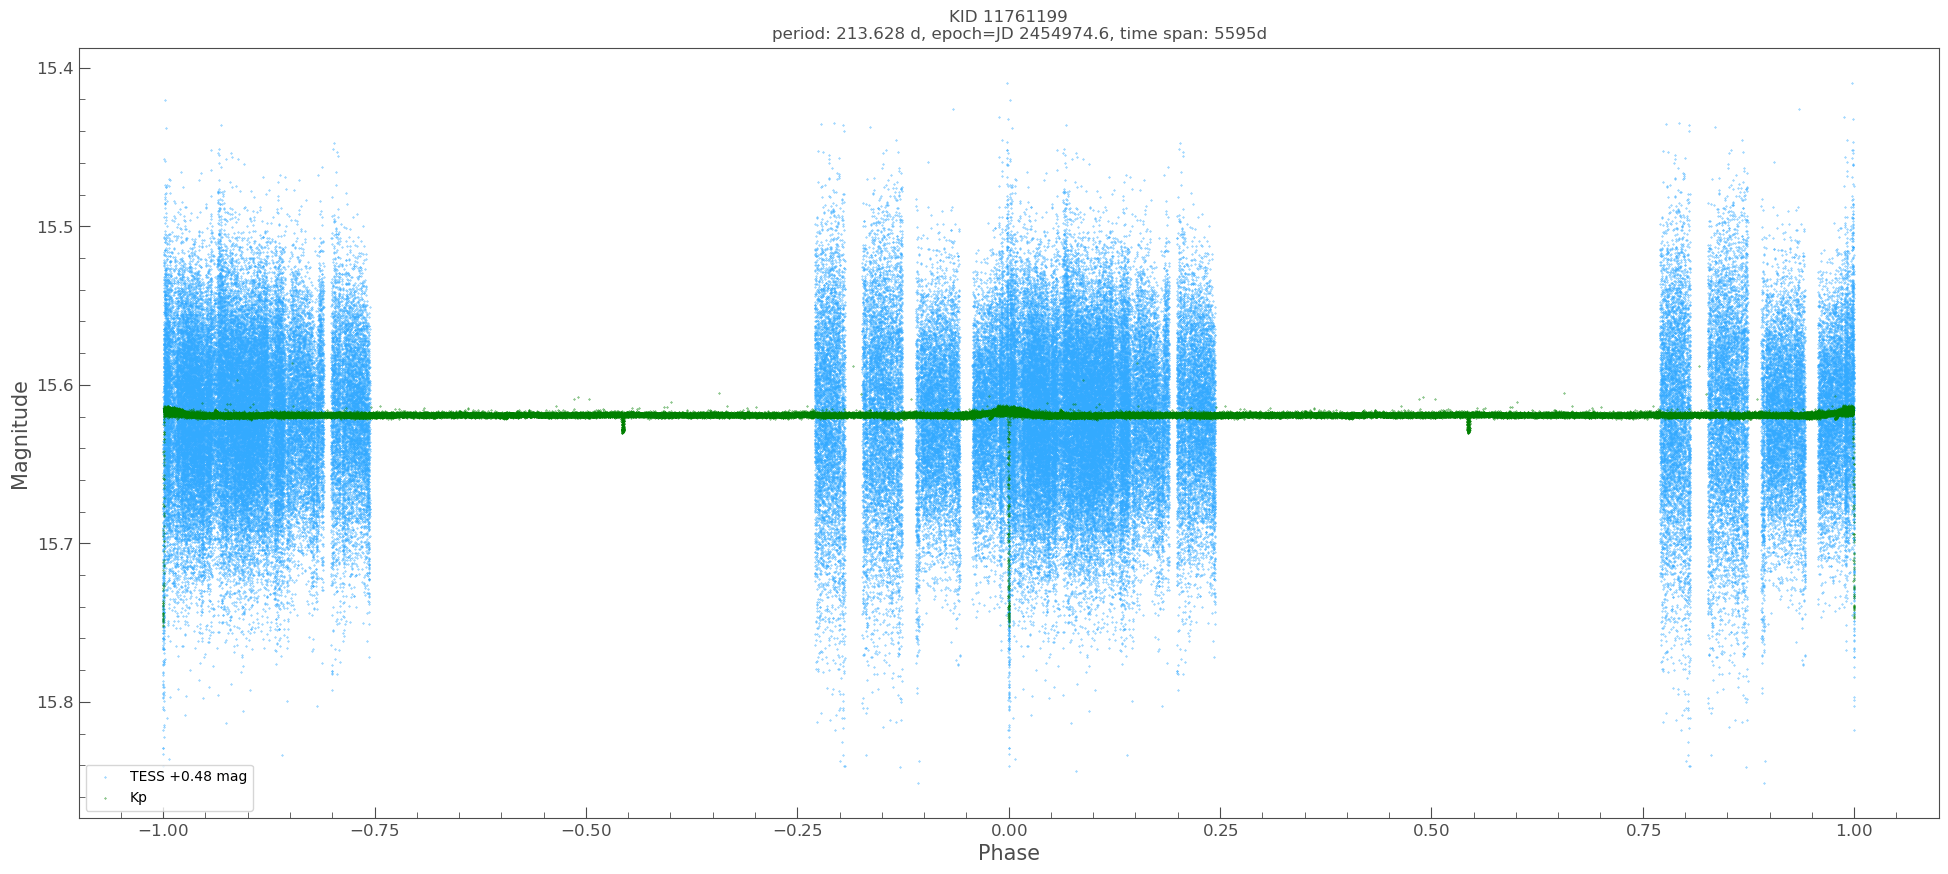

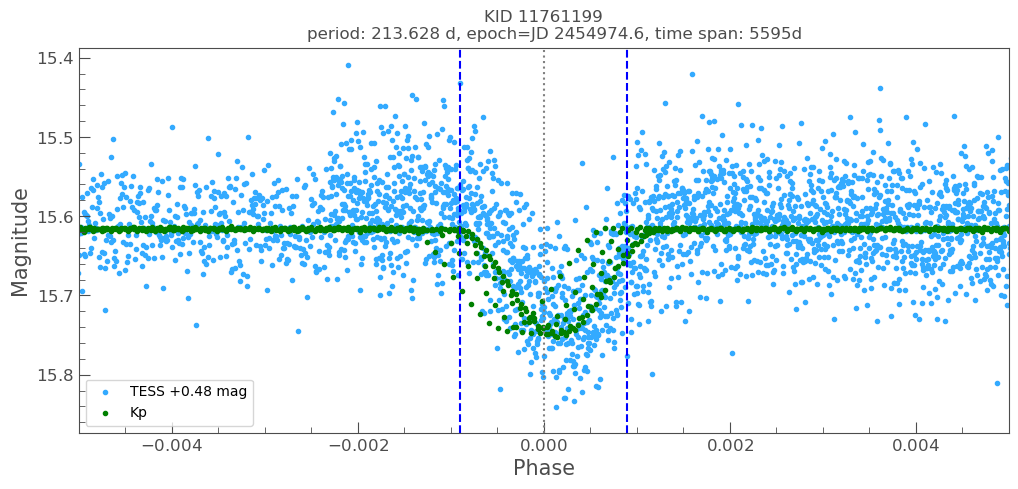

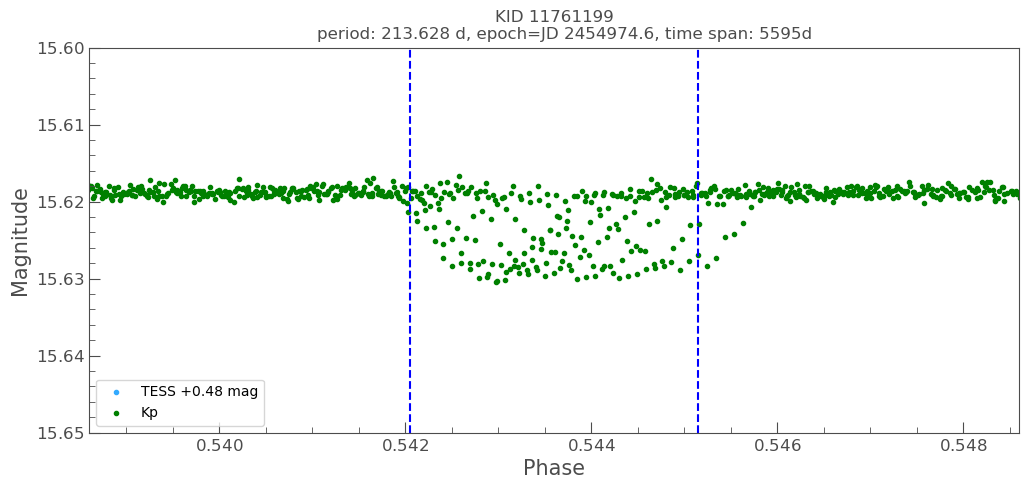

In [7]:
# from https://keplerebs.villanova.edu/overview/?k=11761199

period_trial = round(213.6229022, 2)  # error: 0.0022831  # Kepler EB value
period_trial = 213.628  # override, after fitting with TESS data
epoch_time_bjd_trial = round(54974.635062 + 2400000, 1)  # error: 0.068728


duration_pct_min_i_trial = 100 * 0.0018
duration_pct_min_ii_trial = 100 * 0.0031
duration_hr_min_i_trial = period_trial * duration_pct_min_i_trial  / 100 * 24
duration_hr_min_ii_trial = period_trial * duration_pct_min_ii_trial  / 100 * 24

phase_min_ii_trial = 0.5436


print("Adopted period / epoch / duration_hr: ", period_trial, epoch_time_bjd_trial, duration_hr_min_i_trial)

# --- Plot them ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial,
    epoch=Time(epoch_time_bjd_trial,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.legend(loc="lower left");


# zoom plot Min I
plot_options_zoom = plot_options.copy()
plot_options_zoom[0][1]["s"] = 9
plot_options_zoom[1][1]["s"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial  ,
    epoch=Time(epoch_time_bjd_trial,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.005, 0.005);  # to see primary in details


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial  ,
    epoch=Time(epoch_time_bjd_trial,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_trial  ,  # for plotting only
    duration_midpoint_phase=phase_min_ii_trial,
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (15.65, 15.60)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(phase_min_ii_trial - 0.005, phase_min_ii_trial + 0.005);  # to see secondary in details


## Period refinement

- done in ETV analysis

## Final epoch / period / duration (primary)


Adopted period / epoch / duration_hr:  213.63 2454974.6 9.228815999999998 9.228815999999998


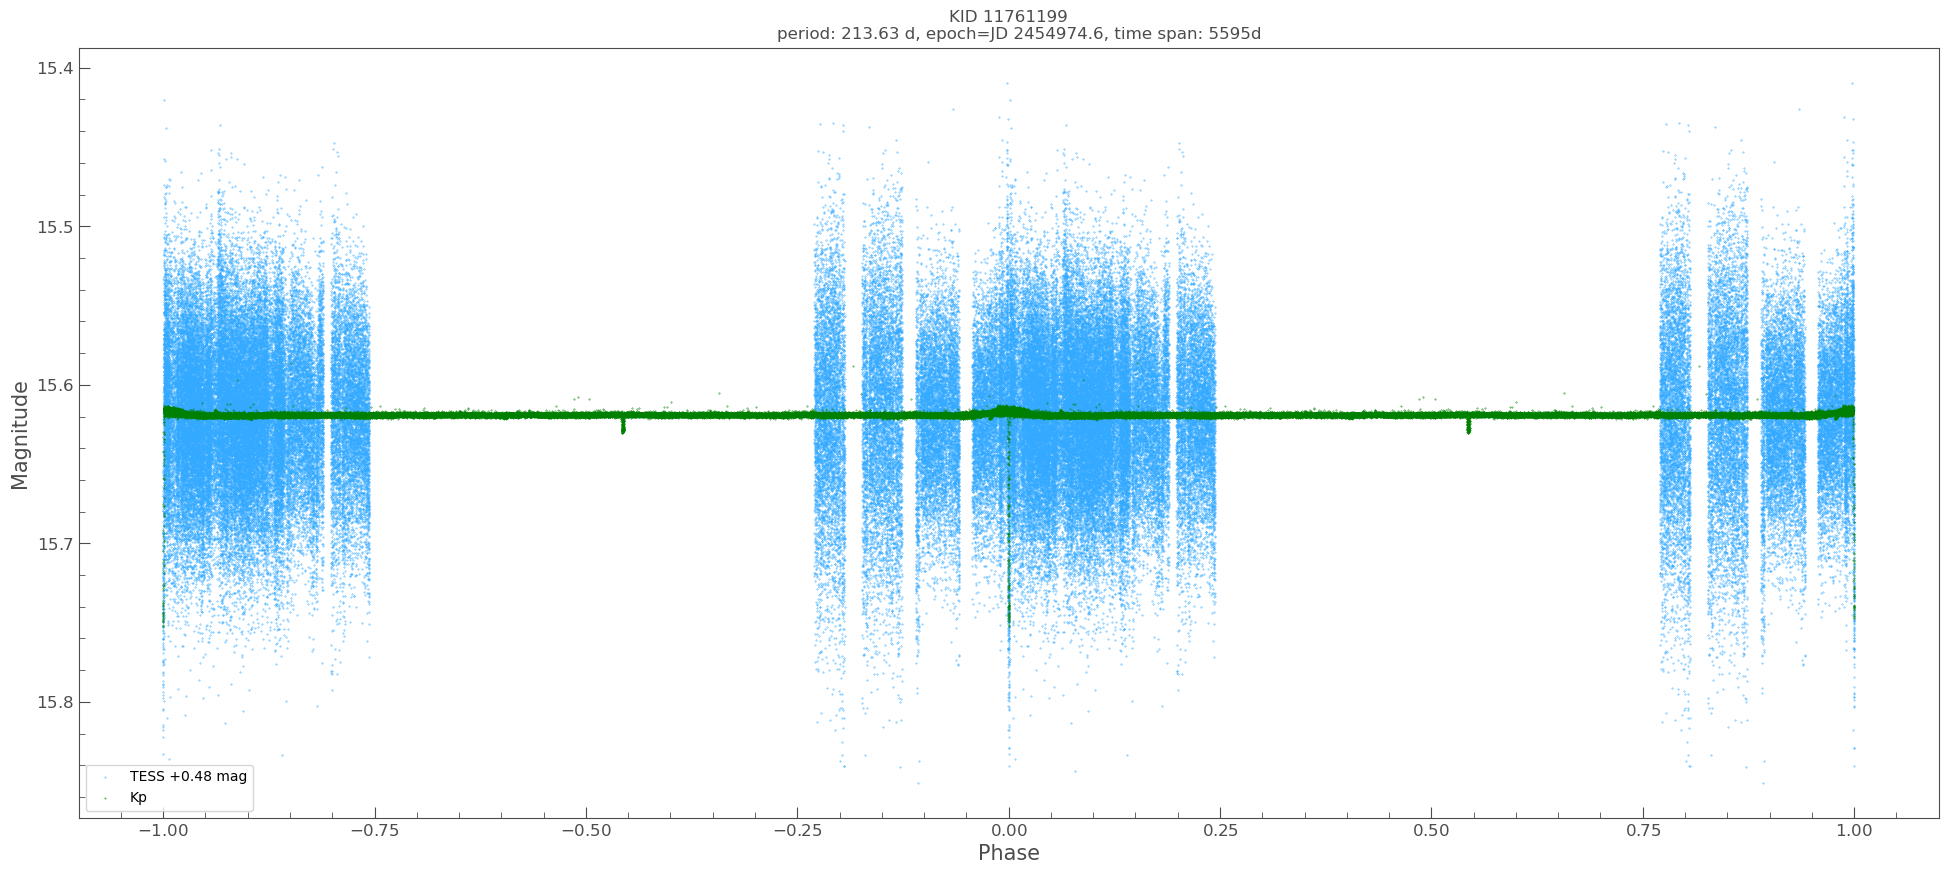

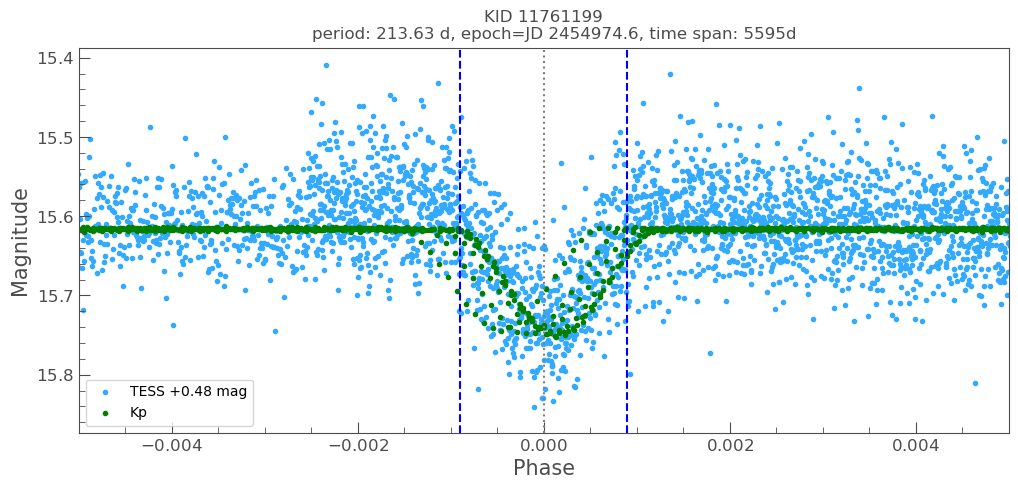

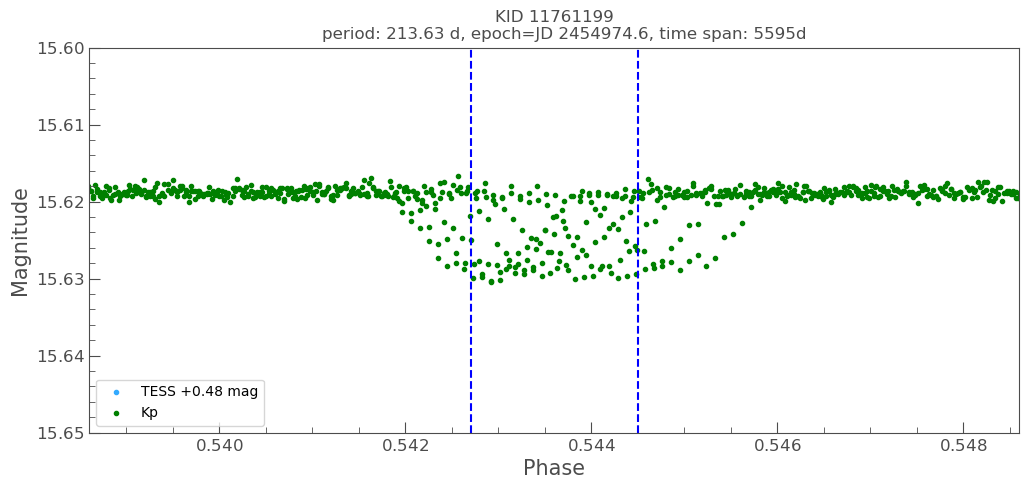

In [33]:
period_final = 213.63  # from ETV analysis

epoch_time_bjd_final = epoch_time_bjd_trial

duration_pct_min_i_final = duration_pct_min_i_trial
duration_pct_min_ii_final = duration_pct_min_i_final  # the Min I duration from Kepler is not reliable, its' widened due to apsidal motion. Actaul duration is about the same as Min I
duration_hr_min_i_final = period_final * duration_pct_min_i_final  / 100 * 24
duration_hr_min_ii_final = period_final * duration_pct_min_ii_final  / 100 * 24
phase_min_ii_final = phase_min_ii_trial


print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_bjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)

# --- Plot them to verify ---

# --- Plot them ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.legend(loc="lower left");


# zoom plot Min I
plot_options_zoom = plot_options.copy()
plot_options_zoom[0][1]["s"] = 9
plot_options_zoom[1][1]["s"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.005, 0.005);  # to see primary in details


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=phase_min_ii_final,
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (15.65, 15.60)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(phase_min_ii_final - 0.005, phase_min_ii_final + 0.005);  # to see secondary in details


## Final epoch / period / duration (secondary)


Adopted secondary period / epoch / phase:  213.554 2455090.97 0.54473


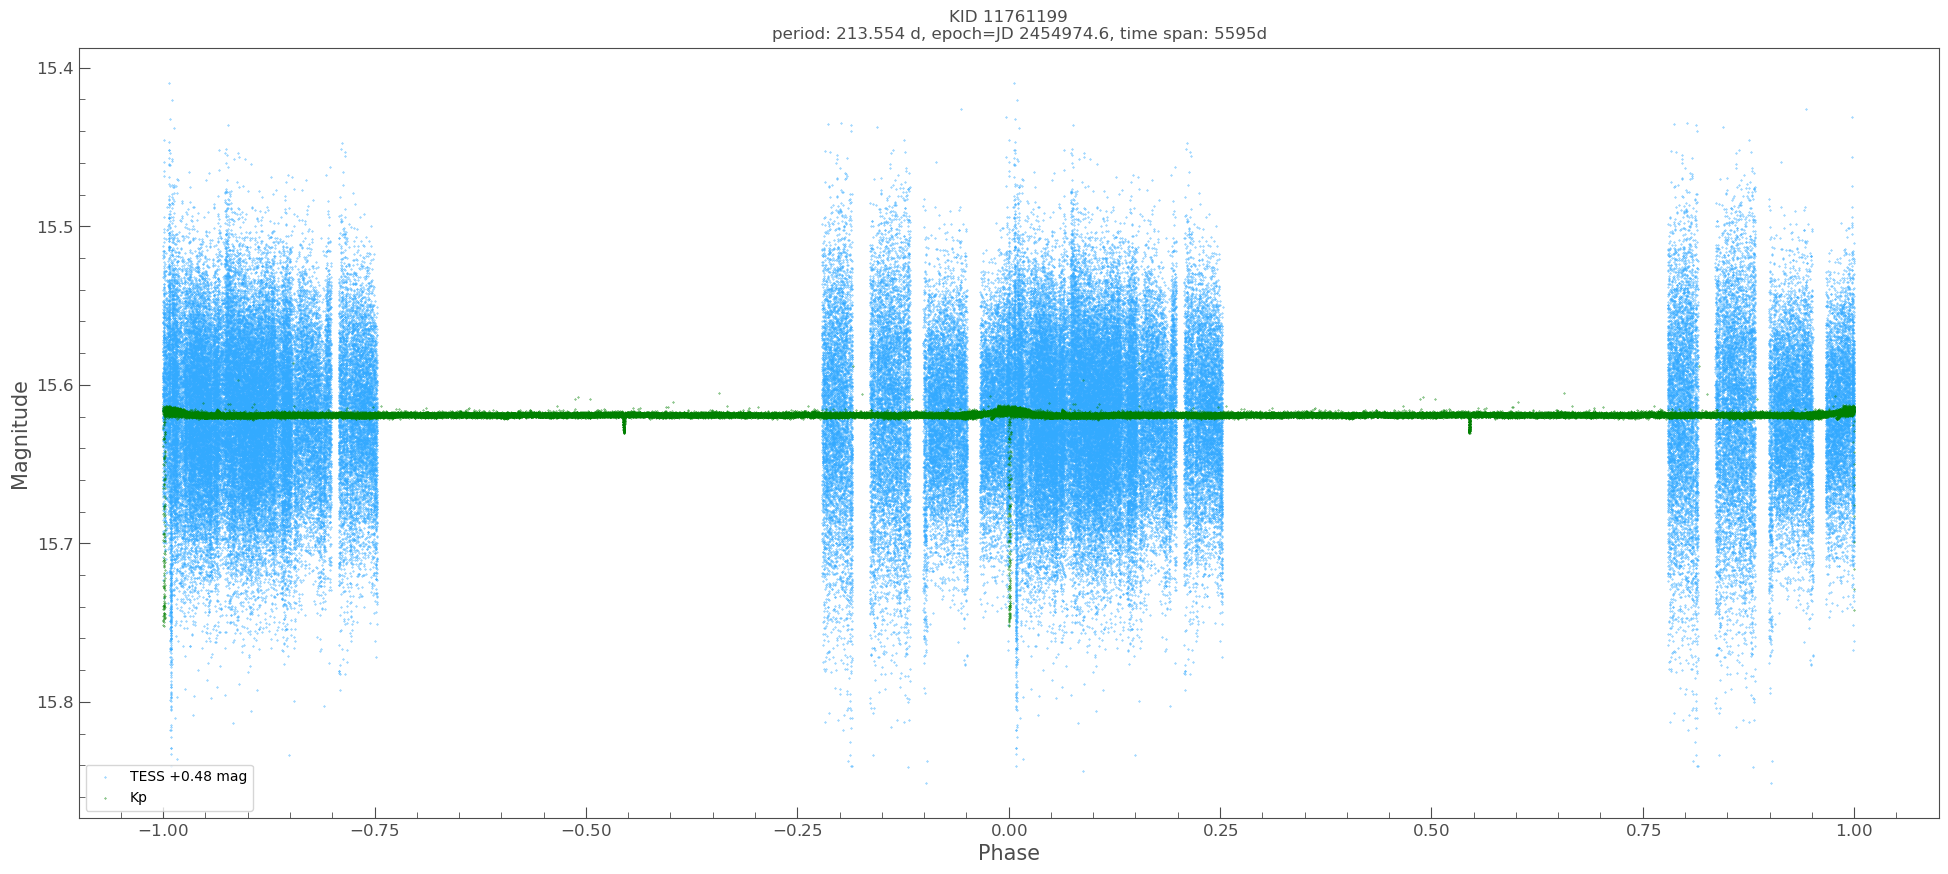

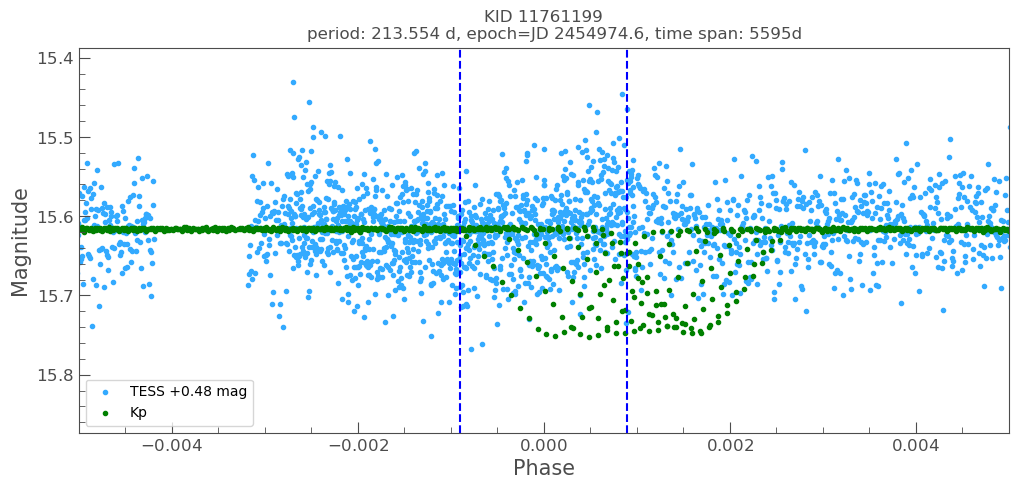

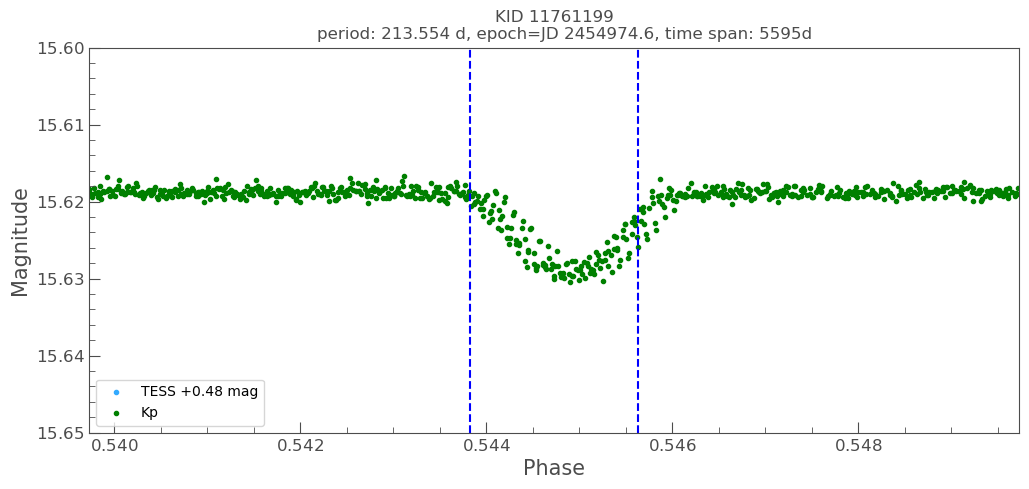

In [100]:
# more accurate eporch / period for Min II
period_min_ii_final = 213.554  # from ETV analysis
epoch_time_min_ii_bjd_final = 2455090.97  # from ETV analysis
phase_min_ii_final = round((epoch_time_min_ii_bjd_final - epoch_time_bjd_final) / period_final, 5)

print("Adopted secondary period / epoch / phase: ", period_min_ii_final, epoch_time_min_ii_bjd_final, phase_min_ii_final)

# --- Plot them to verify ---

# --- Plot them ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_min_ii_final,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.legend(loc="lower left");


# zoom plot Min I
plot_options_zoom = plot_options.copy()
plot_options_zoom[0][1]["s"] = 9
plot_options_zoom[1][1]["s"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_min_ii_final,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.005, 0.005);  # to see primary in details


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_min_ii_final,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=phase_min_ii_final,
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (15.65, 15.60)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(phase_min_ii_final - 0.005, phase_min_ii_final + 0.005);  # to see secondary in details


## Determine Magnitude Range / Amplitude


In [47]:
lc = lc_combined_dict["Kp"]

In [71]:
lke.normalized_amplitude_to_delta_mag(0.1034)

0.1185031636755674

Min I mag # num data points: 7
['15.6190', '15.7470']


(0.128, 0.011)

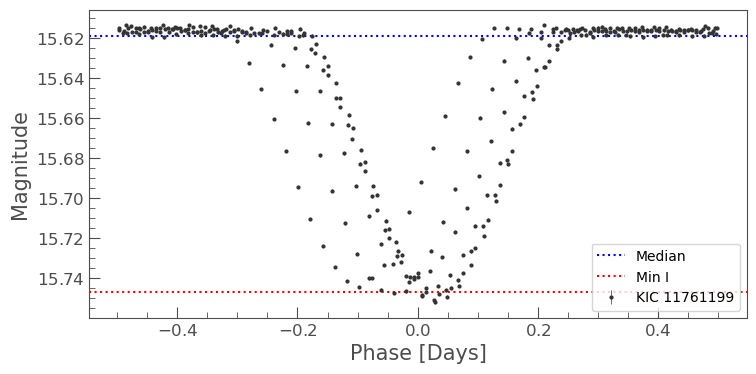

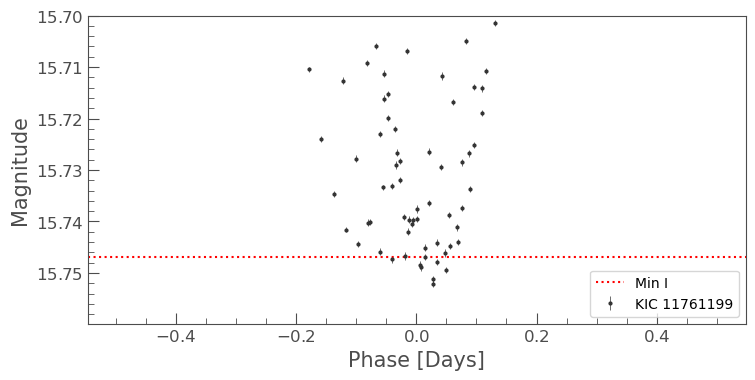

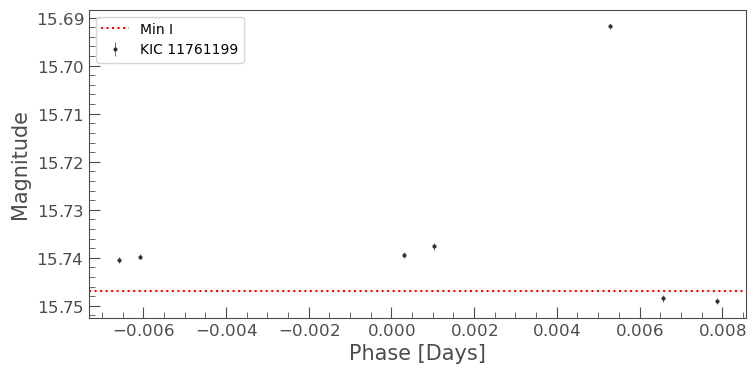

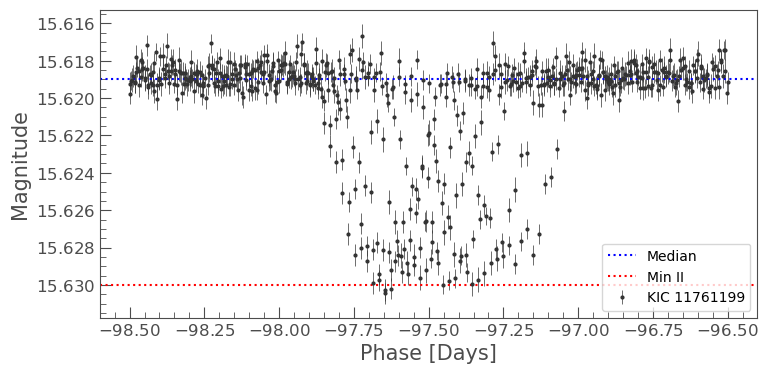

In [77]:
# %matplotlib widget
%matplotlib inline

# From TESS data

# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

# no max neded, medain is basically maax
# lc_zoom_max = lc.fold(epoch_time=epoch_time_bjd_final + 0.75, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)  
# print("Max mag # num data points:", len(lc_zoom_max))
# max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_bjd_final, period=period_final).truncate(0 - 12 /24/60, 0 + 12 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
min_flux_mag = 15.747  # visual override

# lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_bjd_final, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
# print("Min II mag # num data points:", len(lc_zoom_min_ii))
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
# min_ii_flux_mag = median_flux_mag + 0.006  # Kepler EB value, too small
min_ii_flux_mag = median_flux_mag + 0.011  # visual override


lc_f = lc.fold(epoch_time=epoch_time_bjd_final, period=period_final)  # 1x period plot
# ax = tplt.lk_ax(figsize=(12, 8))
# ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
# # ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
# ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# # ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");
# # ax.set_xlim(-0.5, 0.5); 
# ax.set_ylim(*ylim);

# Not applibale here
# ax = tplt.errorbar(lc_zoom_max, marker="o");
# ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
# ax.set_ylim(*ylim);
# ax.legend();

# visualize Min I
lc_trunc_min_i = lc_f.truncate(-0.5 , 0.5)
ax = tplt.errorbar(lc_trunc_min_i, marker="o");
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend(loc="lower right");
ax = tplt.errorbar(lc_trunc_min_i, marker="o");
ax.set_ylim(None, 15.70);  # zoom to the mini values
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend(loc="lower right");

# Min I data points 
ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

# visualize Min II
lc_trunc_min_ii = lc_f.truncate(period_final * (phase_min_ii_final - 1) - 1 , period_final * (phase_min_ii_final - 1) + 1)
ax = tplt.errorbar(lc_trunc_min_ii, marker="o");
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [median_flux_mag, min_flux_mag]])  # , min_ii_flux_mag


# # TESS only data, to report mean V mag and ampitude in TESS
# mean_flux_v_mag = np.round(rs_all_cols["Vmag"][0], 2)  # V converted from Gaia DR3 - here I use other sources

# amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 3)  # in TESS band, probably don't have 4 digit precison

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  
amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  

(amp_min_i_flux_mag, amp_min_ii_flux_mag)  # amp_flux_mag,

In [42]:
## Amplitudes from Kepler EB (no longer used)
# from https://keplerebs.villanova.edu/overview/?k=11761199

# amp_flux_mag = round(lke.normalized_amplitude_to_delta_mag(0.1021), 3)
# amp_min_ii_flux_mag = round(lke.normalized_amplitude_to_delta_mag(0.0051), 3)

# amp_flux_mag, amp_min_ii_flux_mag

(0.117, 0.006)

## Plots for VSX

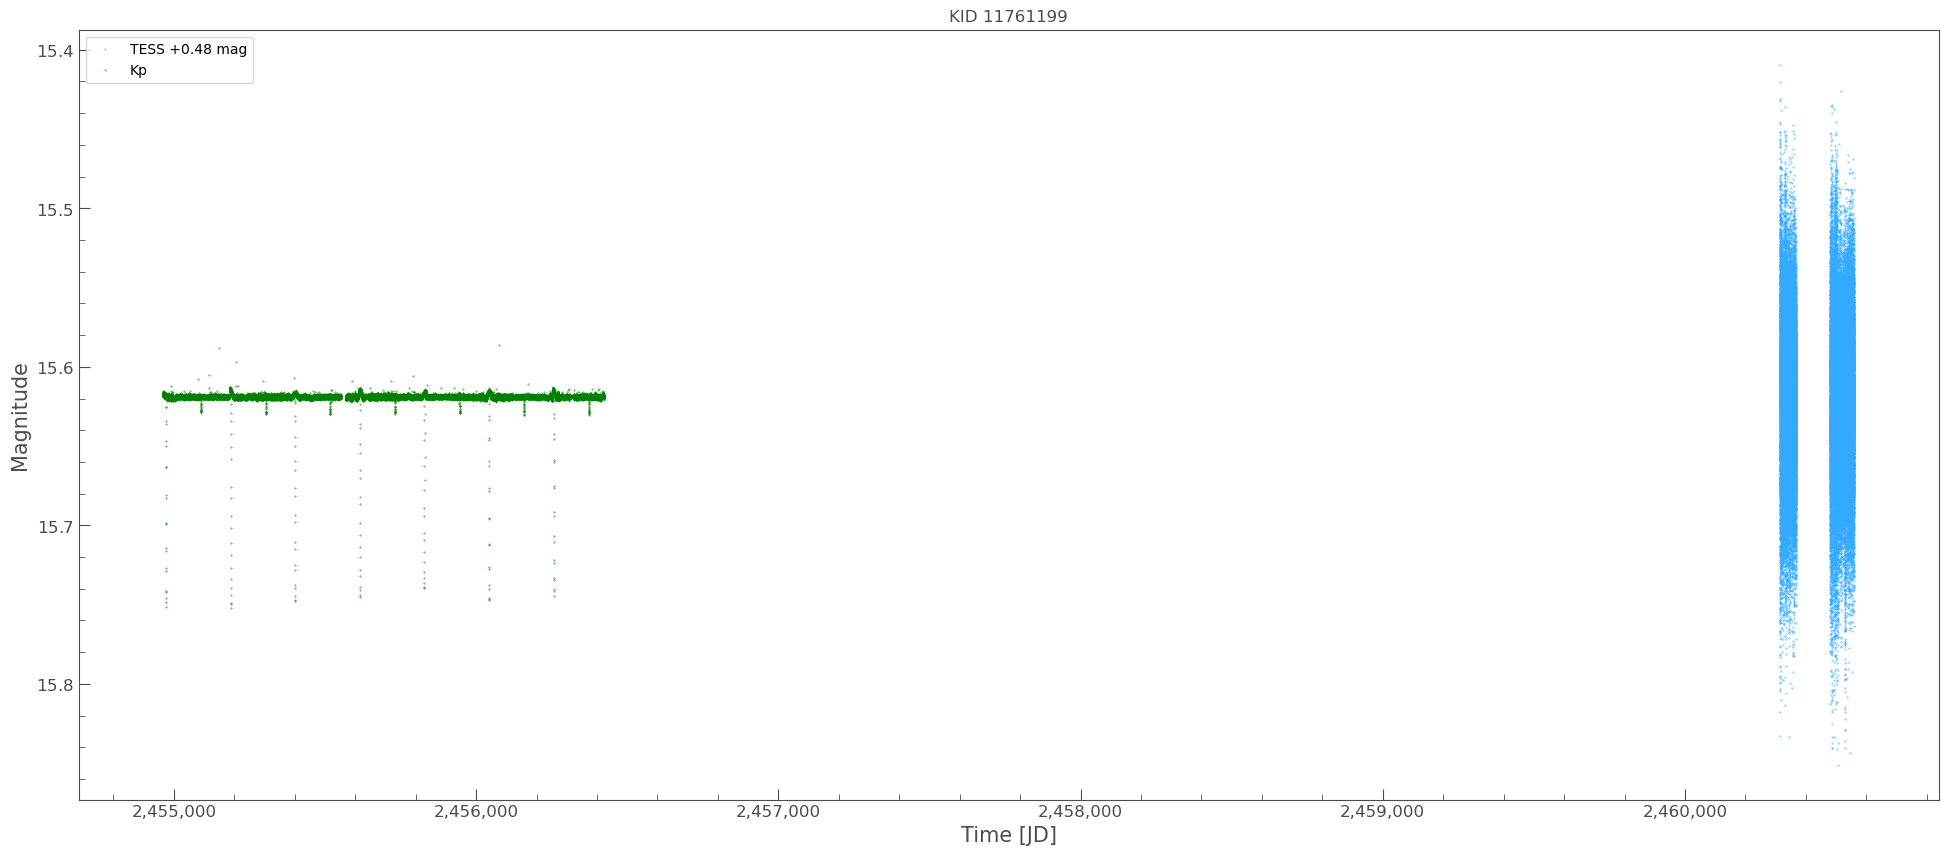

In [35]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
# ax.set_title(ax.get_title() + "");

#### Phase Plot



In [ ]:
lkem.get_default_plot_multi_bands_options_copy()

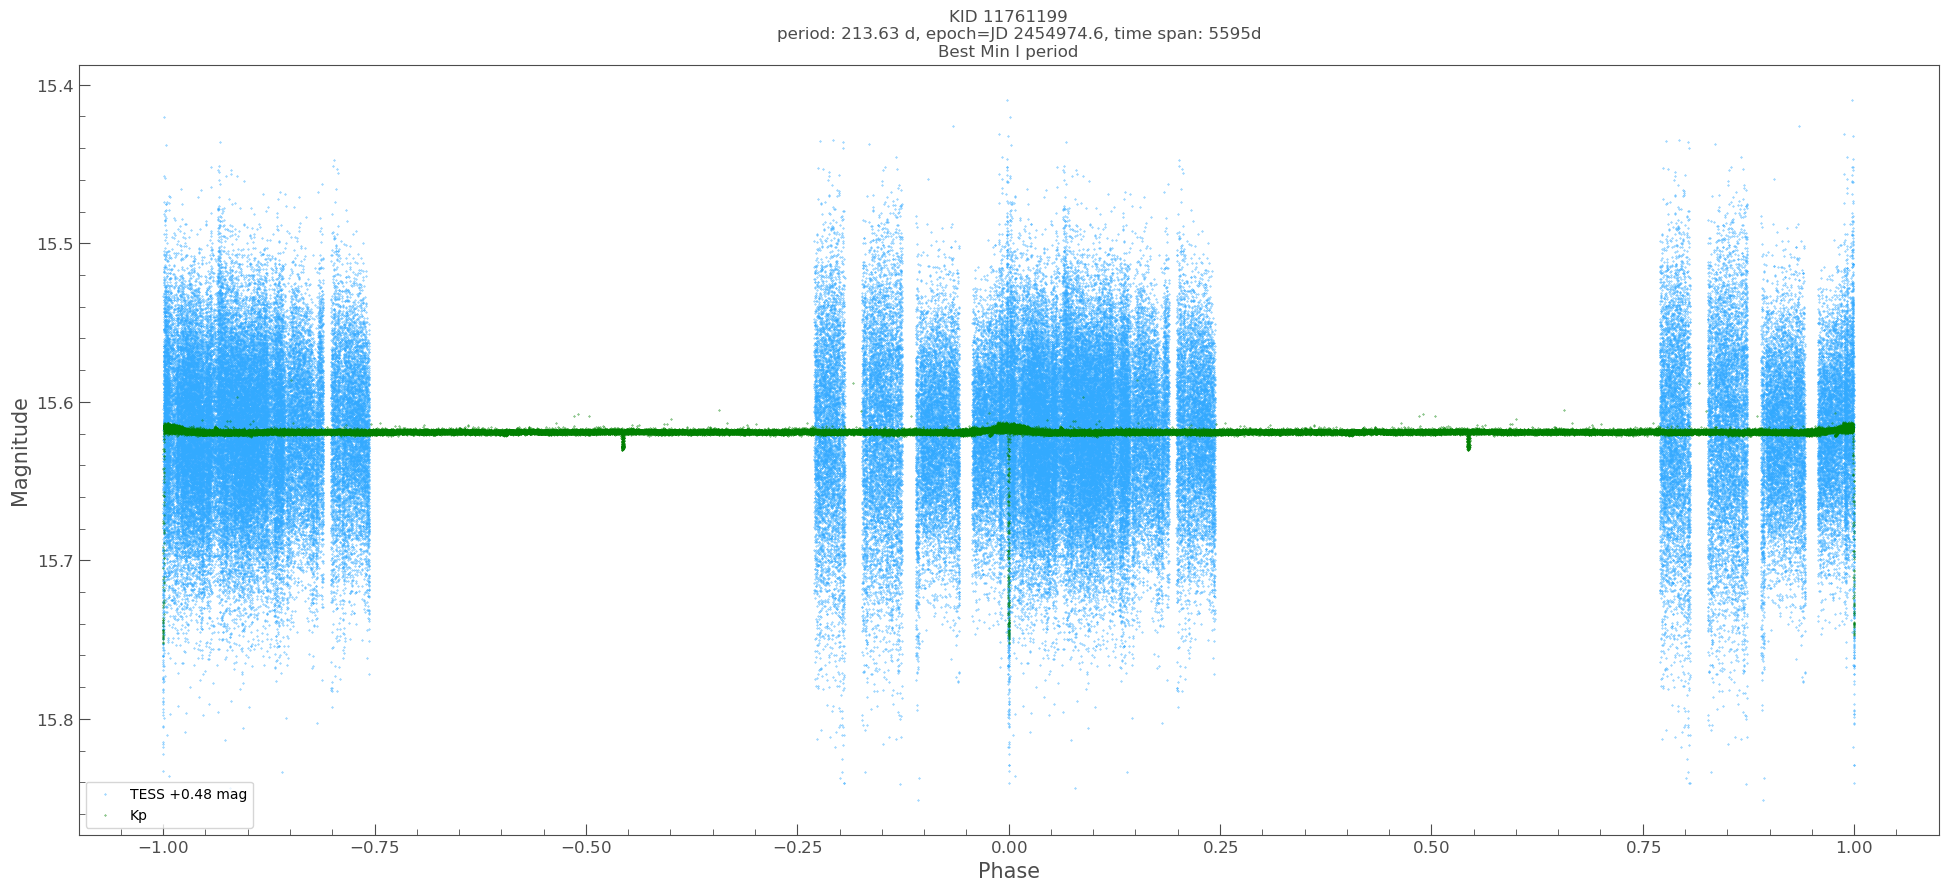

In [113]:
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1] = ('scatter', {'c': 'green', 's': 0.1, 'alpha': 1.0})  # scatter plot for Kepler data

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.legend(loc="lower left");
ax.set_title(ax.get_title() + "\nBest Min I period");

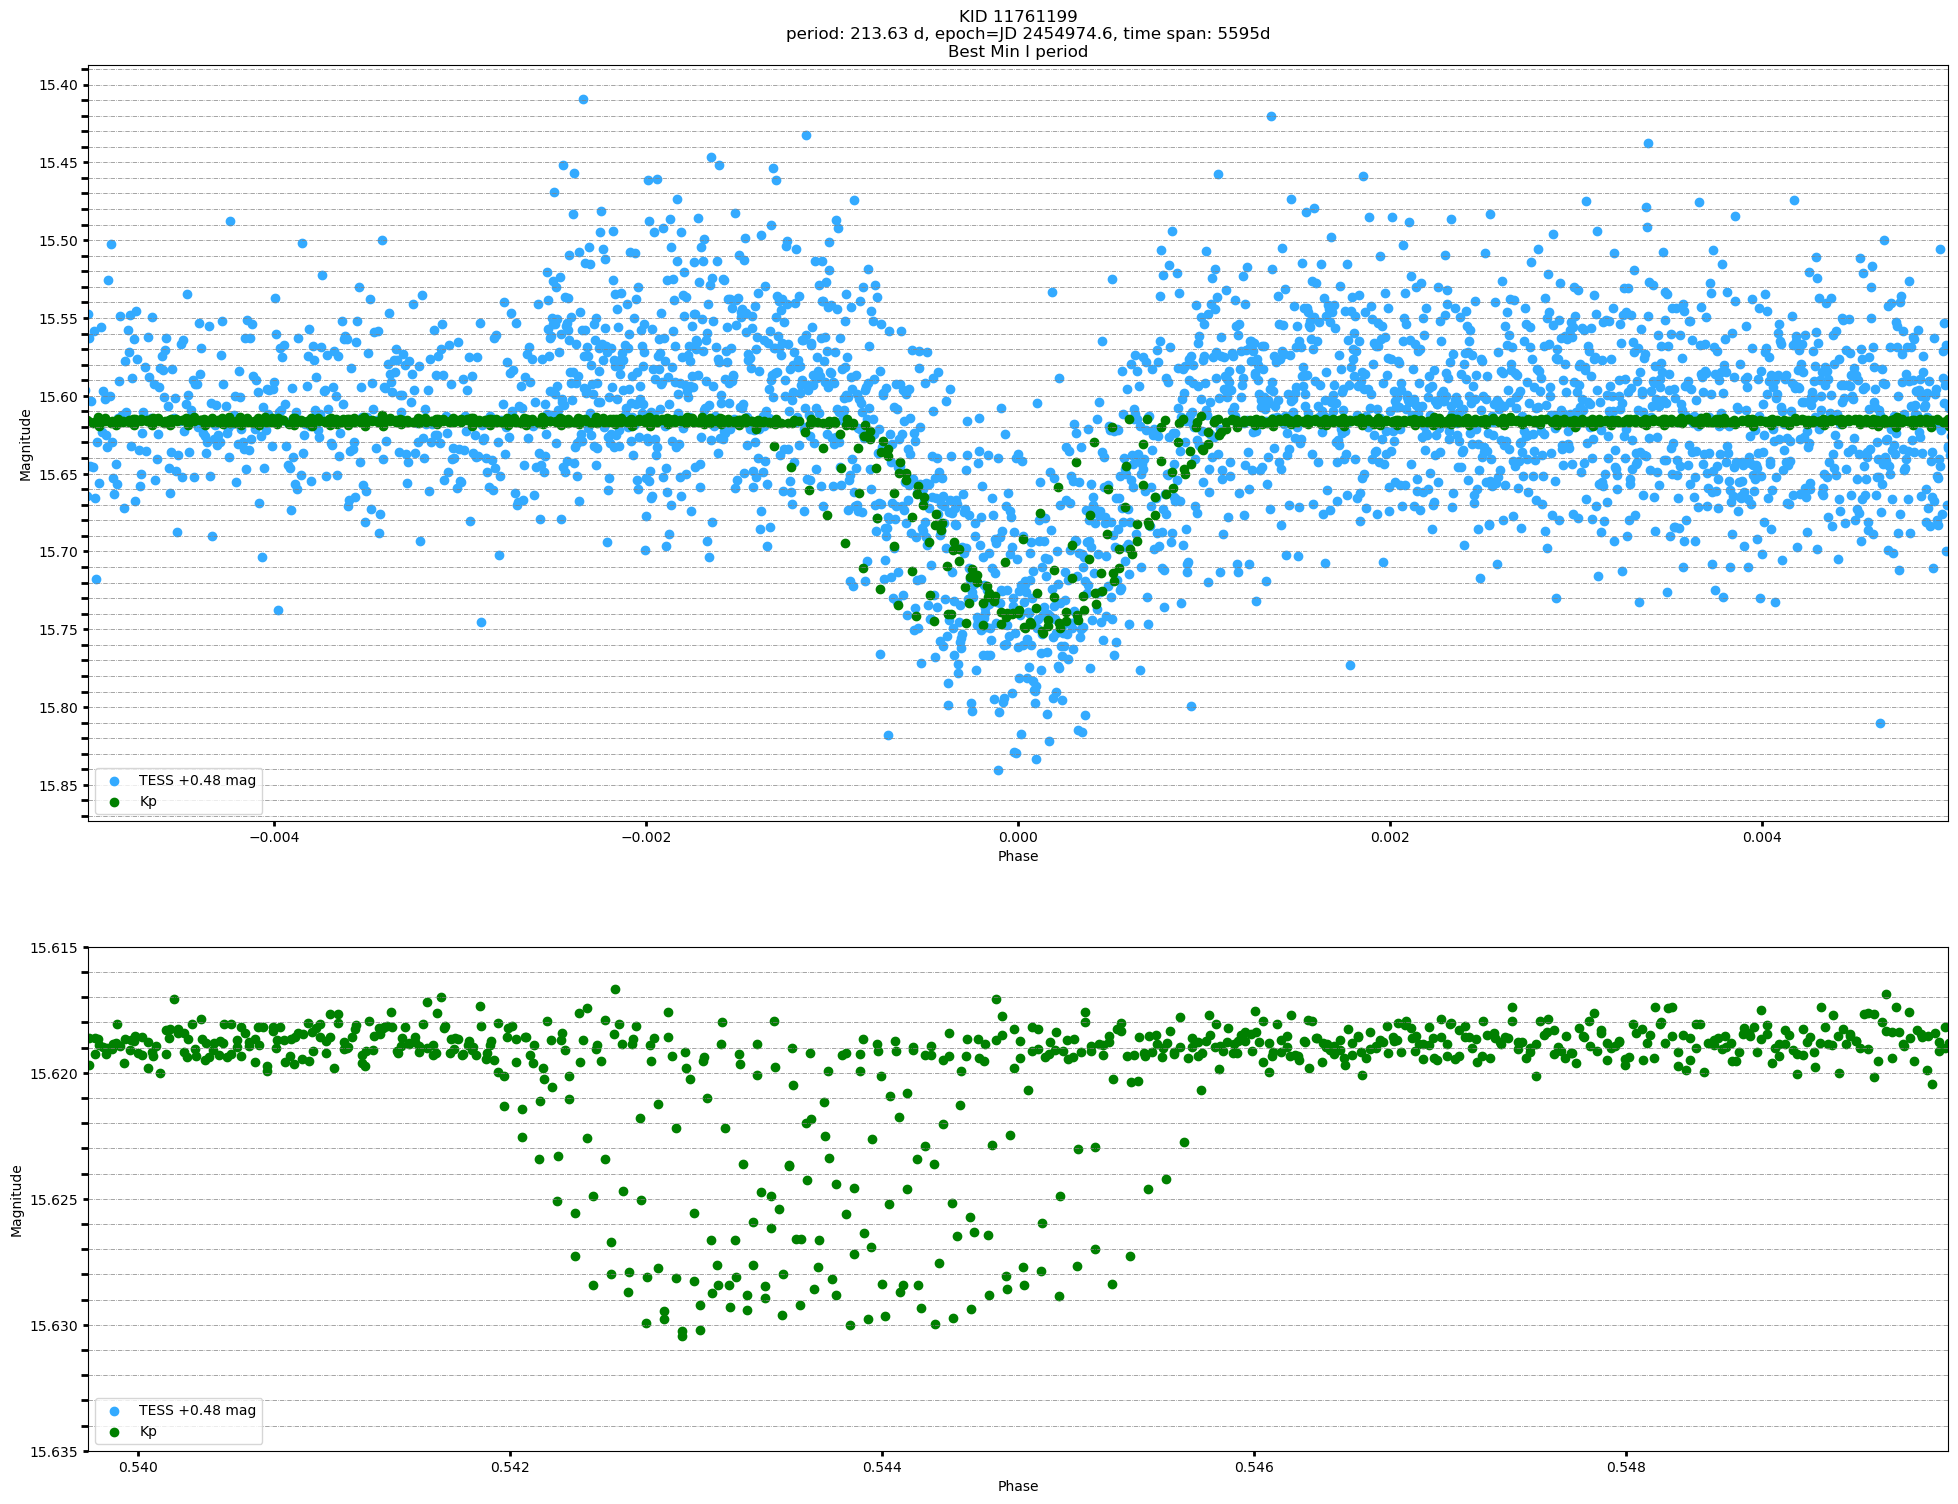

In [139]:
# zoom plot Min I
plot_options_zoom = plot_options.copy()
plot_options_zoom[0][1]["s"] = 36
plot_options_zoom[1][1]["s"] = 36

fig, axs = plt.subplots(2, 1, figsize=(24, 18),  gridspec_kw={'height_ratios': [1.5, 1]})
# plt.tight_layout();

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    ax=axs[0],
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.005, 0.005);  # to see primary in details
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.tick_params(which='major', width=2)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', width=2, length=5)
ax.yaxis.grid(which='both', linestyle='-.', linewidth='0.5', color='gray');
ax.set_title(ax.get_title() + "\nBest Min I period");

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    # duration_midpoint_phase=phase_min_ii_final,
    ax=axs[1],
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (15.635, 15.615)
ax.set_title(None);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(phase_min_ii_final - 0.005, phase_min_ii_final + 0.005);  # to see secondary in details
ax.yaxis.set_major_locator(MultipleLocator(0.005))
ax.tick_params(which='major', width=2)
ax.yaxis.set_minor_locator(AutoMinorLocator(5));
ax.tick_params(which='minor', width=2, length=5);
ax.yaxis.grid(which='both', linestyle='-.', linewidth='0.5', color='gray');

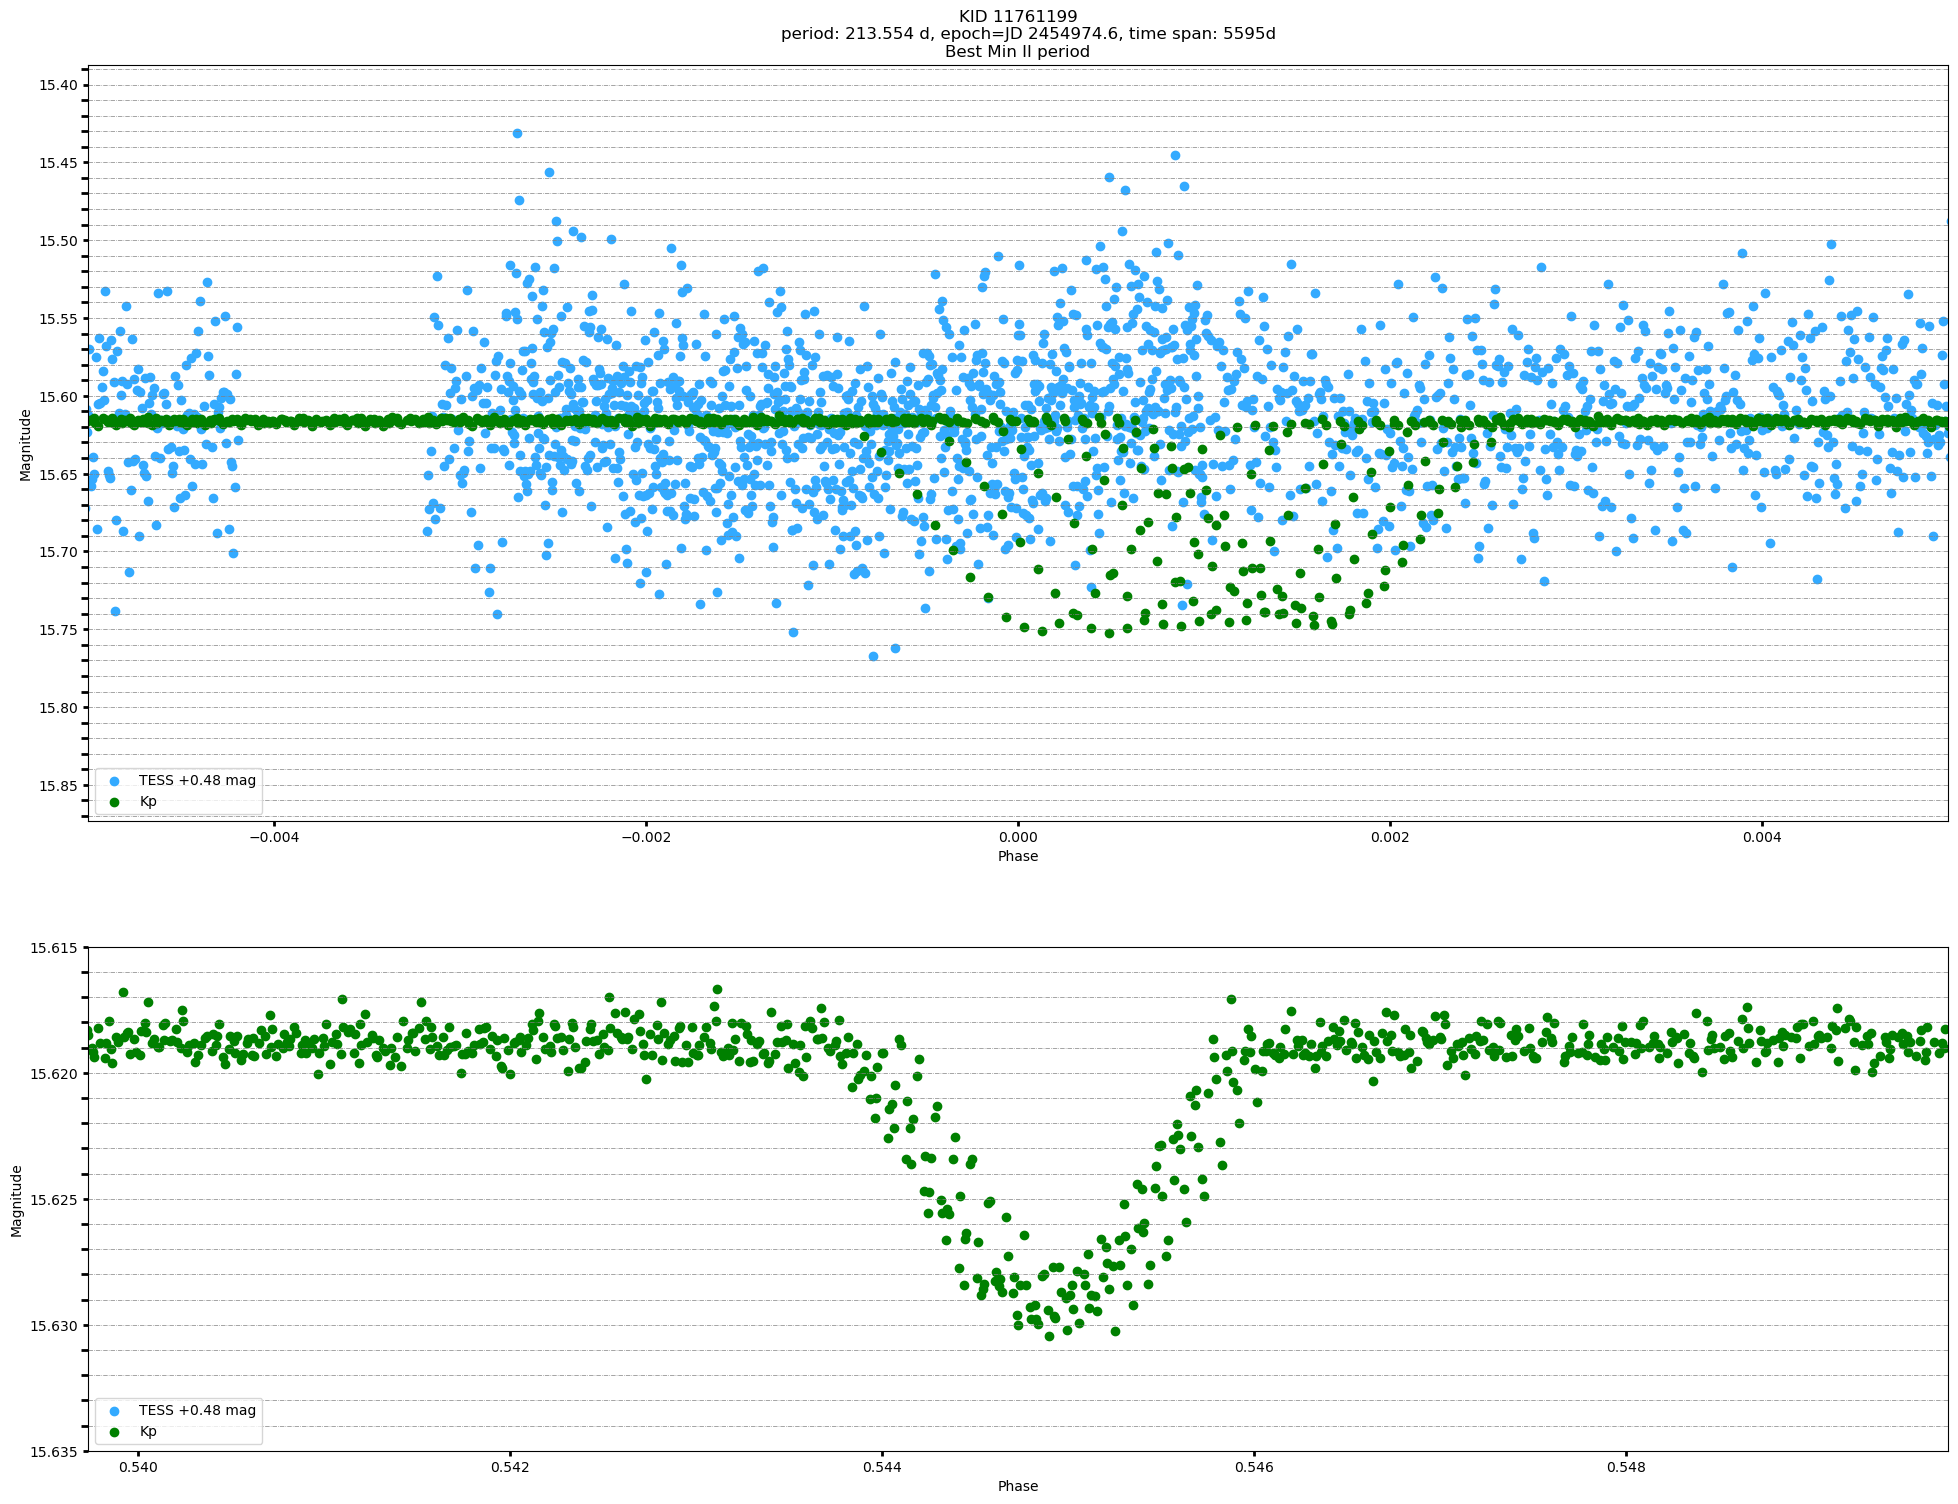

In [138]:
# zoom plot Min I
plot_options_zoom = plot_options.copy()
plot_options_zoom[0][1]["s"] = 36
plot_options_zoom[1][1]["s"] = 36

fig, axs = plt.subplots(2, 1, figsize=(24, 18),  gridspec_kw={'height_ratios': [1.5, 1]})
# plt.tight_layout();

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_min_ii_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    ax=axs[0],
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.005, 0.005);  # to see primary in details
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.tick_params(which='major', width=2)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', width=2, length=5)
ax.yaxis.grid(which='both', linestyle='-.', linewidth='0.5', color='gray');
ax.set_title(ax.get_title() + "\nBest Min II period");

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_min_ii_final  ,
    epoch=Time(epoch_time_bjd_final,format="jd",scale="tdb"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    # duration_midpoint_phase=phase_min_ii_final,
    ax=axs[1],
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (15.635, 15.615)
ax.set_title(None);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(phase_min_ii_final - 0.005, phase_min_ii_final + 0.005);  # to see secondary in details
ax.yaxis.set_major_locator(MultipleLocator(0.005))
ax.tick_params(which='major', width=2)
ax.yaxis.set_minor_locator(AutoMinorLocator(5));
ax.tick_params(which='minor', width=2, length=5);
ax.yaxis.grid(which='both', linestyle='-.', linewidth='0.5', color='gray');

- From my ETV analysis

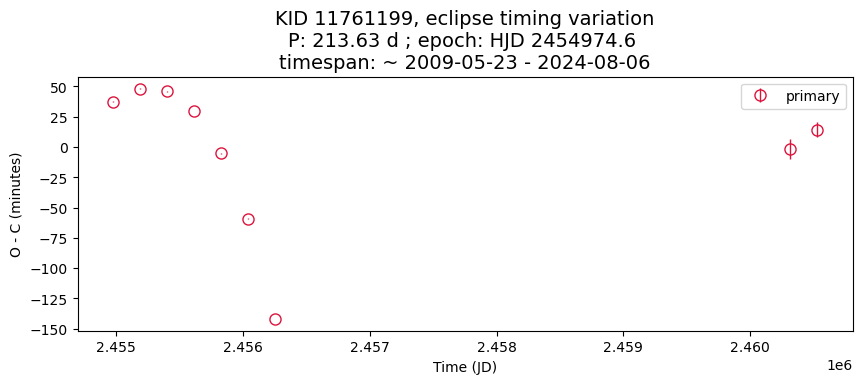


## VSX Report Table

- see also a similar existing VSX entry on HD HD 83742: https://vsx.aavso.org/index.php?view=detail.top&oid=2389868

In [41]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [116]:
import bibs_utils
reload(bibs_utils)


other_names = f"TIC {tic}"  # ExoFOP  and  SIMBAD

remarks = (
    f"""Eccentric system with significant eclipse timing variations and apsidal motion. """
    f"""Min II amplitude {amp_min_ii_flux_mag} Kp at variable orbital phases near {phase_min_ii_final:.2f}. """
    f"""Min II elements: BJD {epoch_time_min_ii_bjd_final} + {period_min_ii_final} x E (Kepler data 2009-2013), duration {duration_pct_min_ii_final}% . """
    f"""Ambiguous identification: in Gaia DR3, it is resolved into 2 stars separated by 0.26", with Vmag 16.46 and 16.12. The position given is the brighter of the two. The magnitude and amplitudes are the composite of the two."""
)

# Techncially, epoch, Min I duration are the same as Kepler EB values, but I've verified them. It's simpler to state that all are derived from data.
revision_comment = "Period, epoch from Kepler and TESS data. Amplitudes, duration from Kepler data. Position from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",  # note: ambiguous ID
    # Primary_Name=primary_name,
    Other_Names=other_names,
    # Variable_Type="EA",
    # Spectral_Type="",
    # Spectral_Type_Uncertain=False,
    # Maximum_Magnitude=f"",  
    # Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_min_i_flux_mag}",
    Minimum_Magnitude_band="Kp",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_bjd_final}",  
    Rise_Duration_Pct=duration_pct_min_i_final, 
    Remarks=remarks,
    Revision_Comment=revision_comment,
    # I started off with Kepler EB values, but override them at the end, so the references are not needed
    # Reference0_Name="Kirk, B.; et al., 2016, Kepler Eclipsing Binary Stars. VII. The Catalog of Eclipsing Binaries Found in the Entire Kepler Data Set ",  
    # Reference0_Bib="2016AJ....151...68K",
    # Reference1_Name="Kepler Eclipsing Binary Catalog (online data)",
    # Reference1_Link="https://keplerebs.villanova.edu/overview/?k=11761199",
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    # Kepler bibs reference. Unsure if it's the preferred bib for VSX.
    Reference1_Name="Borucki, W. J.; et al., 2010, Kepler Planet-Detection Mission: Introduction and First Results",
    Reference1_Bib="2010Sci...327..977B",
)


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

print("""
tic417657237_phase_plot_eclipses_min_i_period.png : EA Phase Plot, primary eclipse period - EA Phase Plot from Kepler and TESS data folded with primary eclipse period
tic417657237_phase_plot_eclipses_min_i_period_zoom.png : EA Phase Plot, primary eclipse period (zoom) - EA Phase Plot from Kepler and TESS data folded with primary eclipse period. Zoomed to primary and seconary eclipses.
tic417657237_phase_plot_eclipses_min_ii_period_zoom.png : EA Phase Plot, secondary eclipse period (zoom) - EA Phase Plot from Kepler and TESS data folded with secondary eclipse period. Zoomed to primary and seconary eclipses.
tic417657237_oc_plot_min_i.png : O-C Plot, primary eclipses - O-C Plot from Kepler and TESS data for primary eclipses.
""")


Other Names (1 line each):
TIC 417657237

Eccentric system with significant eclipse timing variations and apsidal motion. Min II amplitude 0.011 Kp at variable orbital phases near 0.54. Min II elements: BJD 2455090.97 + 213.554 x E (Kepler data 2009-2013), duration 0.18% . Ambiguous identification: in Gaia DR3, it is resolved into 2 stars separated by 0.26", with Vmag 16.46 and 16.12. The position given is the brighter of the two. The magnitude and amplitudes are the composite of the two.

Period, epoch from Kepler and TESS data. Amplitudes, duration from Kepler data. Position from Gaia DR3.


Field  \
0                 Position   
1              Other_Names   
2        Minimum_Magnitude   
3   Minimum_Magnitude_band   
4     Minimum_Is_Amplitude   
5                   Period   
6                    Epoch   
7        Rise_Duration_Pct   
8                  Remarks   
9         Revision_Comment   
10         Reference0_Name   
11          Reference0_Bib   
12         Reference1_Name   
13          Reference1_Bib   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Value  
0                                                                                                                                                                                                                                                                                                                                                                                                                                       290.75180146026, 49.97227096295  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                         TIC 417657237  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                 0.128  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Kp  
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                  True  
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                213.63  
6                                                                                                                                                                                                                                                                                                                                                                           


tic417657237_phase_plot_eclipses_min_i_period.png : EA Phase Plot, primary eclipse period - EA Phase Plot from Kepler and TESS data folded with primary eclipse period
tic417657237_phase_plot_eclipses_min_i_period_zoom.png : EA Phase Plot, primary eclipse period (zoom) - EA Phase Plot from Kepler and TESS data folded with primary eclipse period. Zoomed to primary and seconary eclipses.
tic417657237_phase_plot_eclipses_min_ii_period_zoom.png : EA Phase Plot, secondary eclipse period (zoom) - EA Phase Plot from Kepler and TESS data folded with secondary eclipse period. Zoomed to primary and seconary eclipses.
tic417657237_oc_plot_min_i.png : O-C Plot, primary eclipses - O-C Plot from Kepler and TESS data for primary eclipses.

